# 0 Support Vector Regression (SVR) algorithm

Given a data set $D=\left\{x_i, y_i\right\}_{i=1}^n$ of $N$ points, the method of $\varepsilon$-Support Vector Regression(denoted SVR) fits a function $f$ to the data $D$ of the following form:  


$$
f(x)=w^T \phi(x)+b
$$


We aim to minimize
$$
J(w)=\frac{1}{2}||w||^2+C \sum_{i=1}^n\left|\xi_i\right|
$$
subject to constrains
$$
\left|y_i-w_i \phi(x_i)\right| \leq \varepsilon+\left|\xi_i\right|
$$  


where:

-   $w, b$ are coefficients to be estimated    

-   $\phi(\mathbf{x})$ is a mapping from lower dimensional $x$-space to higer dimensional feature space  

-   $\xi_i$ is a slack variable of the point $x_i$ for dealing with infeasible constraints, for any data point $(x_i, y_i)$ that falls outside of $\varepsilon$, its deviation from the margin is denoted as $\xi_i$   

- $\varepsilon$ : distance from margins to hyperplane, only data points with absolute error less than or equal to $\varepsilon+\left|\xi_i\right|$ will be considered
 
-   $C$ is a positive constant that controls the penalty imposed on observations that lie outside the margin specified $\epsilon$, as $C$ increases, the tolerence for points outside margins increases 

One great advantage of SVMs is that solving for the optimal parameters is equivalent to a convex optimization problem, in which case all local optimum are also global.  

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

from preprocess import *
from callbacks import *

# 1 Data

Read data from `data.csv`:

In [ ]:
parent_path = str(pathlib.Path(os.getcwd()).parent)
df = pd.read_csv(os.path.join(parent_path, 'data/data.csv'))
df.head()

,Unnamed: 0,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility
0,0,150034236.0,504569.0,0.42,C,2006-10-18,0.0715,0.07025,0.488500,5.0,2.0,1.163095,0.053646,0.022956
1,1,150247468.0,504880.0,40.00,C,2006-10-18,0.1240,0.12250,39.913799,56137.0,2.0,0.997845,0.053646,0.114784
2,2,150255000.0,506496.0,62.00,C,2006-10-18,0.1720,0.17400,61.827798,27369.0,2.0,0.997223,0.053646,0.106823
3,3,150255496.0,506497.0,53.50,C,2006-10-18,0.2960,0.26550,53.612900,1224.0,2.0,1.002110,0.053646,0.110336
4,4,150255498.0,506497.0,54.00,C,2006-10-18,0.0750,0.06450,53.612900,963.0,2.0,0.992831,0.053646,0.110336


`dataframe_BS` contains the data from `df`, which is used to train the SVR model.

`small_dataframe_BS` contains 20% of the data from `df`, which is used to perform hyperparamter tuning.

In [ ]:
dataframe_BS = makeBS(df)

small_ds = df.sample(frac=0.2, random_state=42)
small_dataframe_BS = makeBS(small_ds)

Get train and test data in tuples of features and targets. Print out their dimensions to check they are in shapes we want.

In [ ]:
(x_train, y_train) , (x_test, y_test)= propocessed(dataframe_BS)
print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))
(small_x_train, small_y_train) , (small_x_test, small_y_test)= propocessed(small_dataframe_BS)
print(np.shape(small_x_train), np.shape(small_y_train), np.shape(small_x_test), np.shape(small_y_test))

(85999, 5) (85999,) (21500, 5) (21500,)
(17200, 5) (17200,) (4300, 5) (4300,)


# 2 Model

In this approach, we use the radial basis function (RBF) as a transformation kernel for our data.    

For a pair of data points $x_i, x_j$, the RBF is defined as  

$$
k(x_i, x_j) = \exp(-\gamma ||x_i-x_j||)
$$  

where $\gamma$ is a positive hyperparameter.

## Fit the model

In [ ]:
regressor = SVR(kernel = 'rbf')

In [6]:
regressor.fit(x_train, y_train)

SVR()

## Evaluate the model

First, use the trained model to obtain the predicted values:

In [7]:
y_pred_svr = regressor.predict(x_test)

Using RMSE (root mean square error):
$$
R M S E=\sqrt{\frac{1}{N} \sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2}
$$
- $y_i$: true value
- $\hat{y}_i$: predicted value

In [8]:
mse = np.mean((y_test-y_pred_svr)**2)
mse

0.008837280500941

Using MAPE (mean absolute percentage error):
$$
\mathrm{MAPE}=\frac{1}{N} \sum_{t=1}^N\left|\frac{y_t-\hat{y}_t}{y_t}\right|
$$
- $y_i$: true value
- $\hat{y}_i$: predicted value

In [9]:
mape = np.mean((np.abs((y_test-y_pred_svr)/y_test)))
mape

0.5140247086590811

# 3 Tuning hyperparameters

The ranges of hyperparameter are chosen based on experiments in [Practical Option Pricing with
Support Vector Regression and MART
by
Ian I-En Choo
Stanford University](http://cs229.stanford.edu/proj2009/Choo.pdf).

In [10]:
C_range = np.logspace(1,3,3)
print(f'The list of values for C are {C_range}')

epsilon_range = np.logspace(-1,-3,3)
print(f'The list of values for epsilon are {epsilon_range}')

gamma_range = np.logspace(-5, -2, 4)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [  10.  100. 1000.]
The list of values for epsilon are [0.1   0.01  0.001]
The list of values for gamma are [1.e-05 1.e-04 1.e-03 1.e-02]


In [11]:
param_grid = { 
    # Regularization parameter
    "C": C_range,
    # Kernel type
    "kernel": ['rbf'],
    # margin parameter
    "epsilon":epsilon_range,
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }

# Set up score
scoring = ['neg_mean_squared_error']


## Hyperparameter Tuning Using Grid Search

In [16]:
# Define grid search
grid_search = GridSearchCV(estimator=regressor, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='neg_mean_squared_error', 
                           n_jobs=-1,
                           cv = 3,
                           verbose=1)

In [17]:
# Fit grid search
grid_result = grid_search.fit(small_x_train, small_y_train)
# Print grid search summary
grid_result

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([  10.,  100., 1000.]),
                         'epsilon': array([0.1  , 0.01 , 0.001]),
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 'scale', 'auto'],
                         'kernel': ['rbf']},
             refit='neg_mean_squared_error', scoring=['neg_mean_squared_error'],
             verbose=1)

In [18]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {grid_search.score(x_test, y_test):.4f}')

The best accuracy score for the training dataset is -0.0050
The best hyperparameters are {'C': 100.0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy score for the testing dataset is -0.0053


In [19]:
best_regressor = grid_result.best_estimator_
y_pred_grid = best_regressor.predict(x_test)

In [20]:
mse = np.mean((y_test-y_pred_grid)**2)
mse

0.0053332764920681

In [35]:
mape = np.mean((np.abs((y_test-y_pred_grid)/y_test)))
mape

0.40052887520731595

## Hyperparameter Tuning Using Random Search

In [21]:
# Define random search
random_search = RandomizedSearchCV(estimator=regressor, 
                           param_distributions=param_grid, 
                           scoring=scoring, 
                           refit='neg_mean_squared_error', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)
# Fit grid search
random_result = random_search.fit(small_x_train, small_y_train)
# Print grid search summary
random_result

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
                   param_distributions={'C': array([  10.,  100., 1000.]),
                                        'epsilon': array([0.1  , 0.01 , 0.001]),
                                        'gamma': [1e-05, 0.0001, 0.001, 0.01,
                                                  'scale', 'auto'],
                                        'kernel': ['rbf']},
                   refit='neg_mean_squared_error',
                   scoring=['neg_mean_squared_error'], verbose=1)

In [22]:
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {random_result.best_params_}')

The best hyperparameters are {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.001, 'C': 10.0}


In [23]:
best_regressor = random_result.best_estimator_
y_pred_rd = best_regressor.predict(x_test)

In [24]:
mse = np.mean((y_test-y_pred_rd)**2)
mse

0.0060509320655922575

In [25]:
mape = np.mean((np.abs((y_test-y_pred_rd)/y_test)))
mape

0.42613191157869007

## Hyperparameter Tuning Using Bayesian Optimization

In [27]:
# Space
space = {
    'C' : hp.choice('C', C_range),
    'epsilon':hp.choice('epsilon', epsilon_range),
    'gamma' : hp.choice('gamma', gamma_range.tolist()+['scale', 'auto']),
}

# Objective function
def objective(params):
    
    svr = SVR(**params)
    scores = cross_val_score(svr, small_x_train, small_y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# list of losses
losses = []

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, early_stop_fn = no_progress_loss(), trials = bayes_trials, timeout=600)

  0%|          | 38/9223372036854775807 [06:43<27179995499035465:57:20, 10.61s/trial, best loss: 0.004597058456552683]


In [28]:
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

{'C': 2, 'epsilon': 0, 'gamma': 4}
{'C': 1000.0, 'epsilon': 0.1, 'gamma': 'scale'}


In [29]:
# Train model using the best parameters
svc_bo = SVR(C=space_eval(space, best)['C'], gamma=space_eval(space, best)['gamma']).fit(small_x_train, small_y_train)

In [30]:
y_pred_bo = svc_bo.predict(x_test)

In [31]:
mse = np.mean((y_test-y_pred_bo)**2)
mse

0.005816476841988445

In [32]:
mape = np.mean((np.abs((y_test-y_pred_bo)/y_test)))
mape

0.535042447922126

### Visualization of Hyperparameter Tuning using Bayesian Optimization

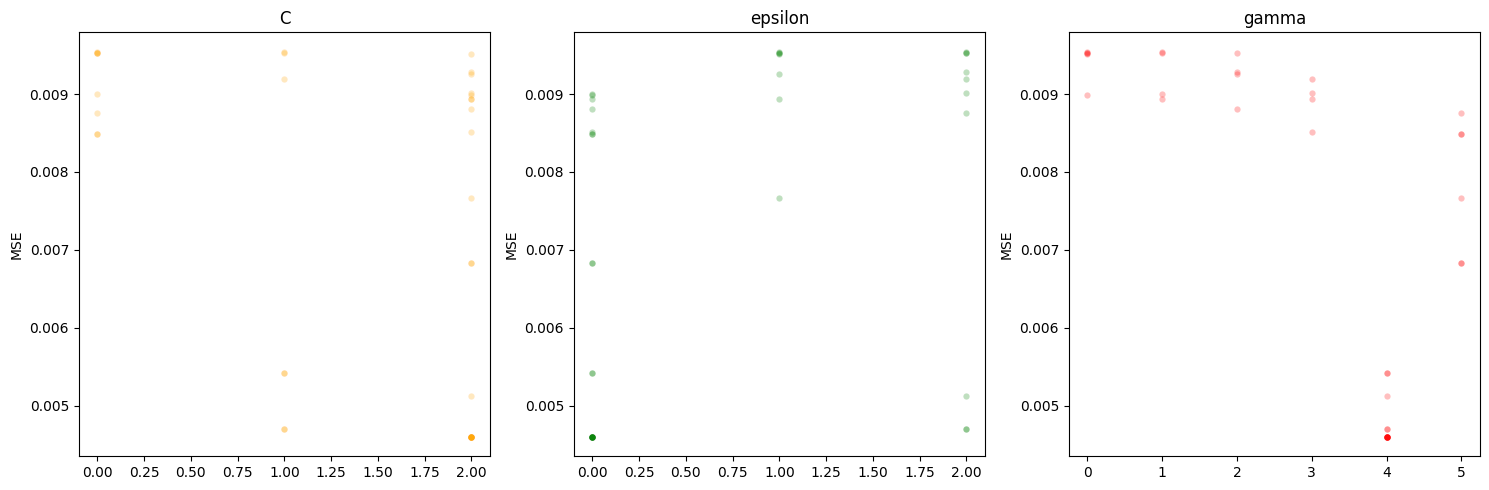

In [33]:
parameters = ['C', 'epsilon', 'gamma']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
colors = ['orange', 'green', 'red']
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in bayes_trials.trials]).ravel()
    ys = [t['result']['loss'] for t in bayes_trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25, c = colors[i])
    axes[i].set_title(val)
    axes[i].set_ylabel('MSE')
f.tight_layout()
plt.show()

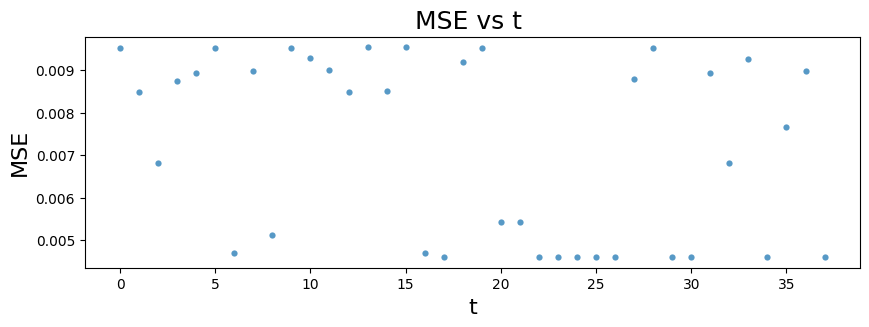

In [34]:
f, ax = plt.subplots(1,figsize=(10,3))
xs = [t['tid'] for t in bayes_trials.trials]
ys = [t['result']['loss'] for t in bayes_trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('MSE vs t ', fontsize=18)
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('MSE', fontsize=16)
plt.show()